In [3]:
import joblib
import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas

from cogpred.utils.configuration import get_config
from cogpred.transformers import MatrixMasker
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

config = get_config()
conn_dir = config["connectivity_matrices"]

ATLAS = "schaefer200"

atlas = Atlas.from_name(ATLAS)

k = 3
#REFNET = np.unique(atlas.macro_labels)
#INTER = REFNET
REFNET = ("Default",)
INTER = ("Default",)

sns.reset_defaults()
# TODO Deconfounding in the pipeline?

In [4]:
matrices, metadata = make_training_data(conn_dir, ATLAS, k)
run_path = make_run_path(
    config["output_dir"],
    k=k,
    feat="fc",
    atlas=ATLAS,
    net="".join(REFNET),
    inter="".join(INTER)
)

if len(run_path.name) > 55:
    print("too long")
    run_path = make_run_path(
        config["output_dir"],
        k=k,
        feat="fc",
        atlas=ATLAS,
        net="all",
    )
    
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 9 subjects because of lacking MMMSE


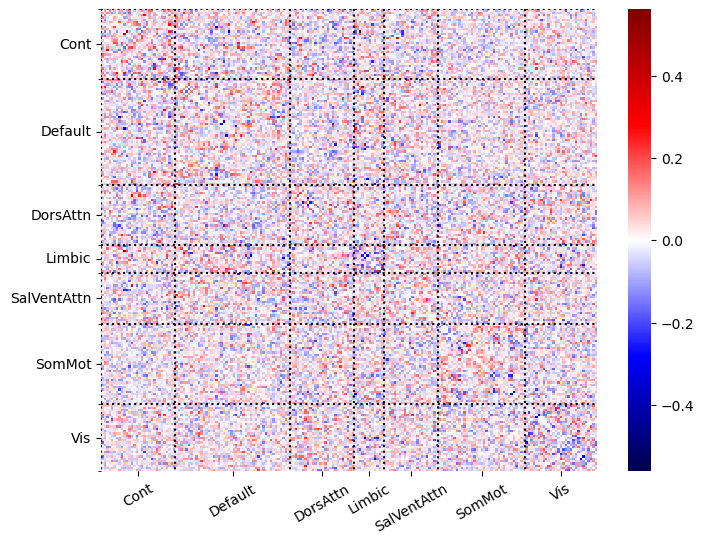

In [5]:
n_regions = matrices.shape[1]
plot_matrix(matrices[1], atlas)
plt.show()

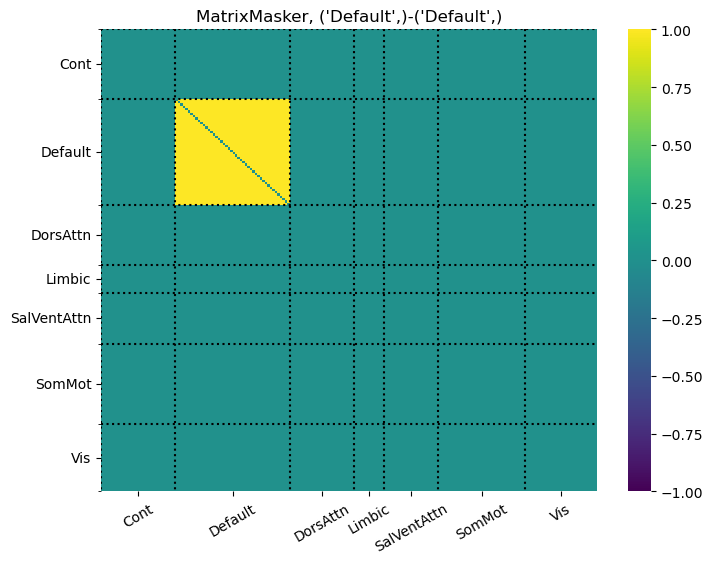

In [6]:
masker = MatrixMasker(REFNET, INTER, atlas=atlas).fit(matrices, metadata)

masker.fit(matrices).plot(cmap="viridis")
plt.show()

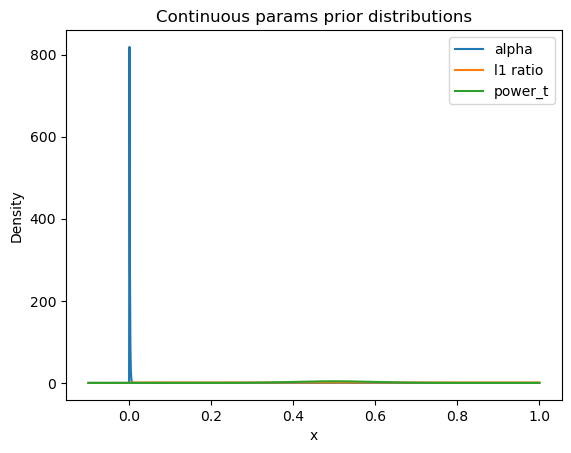

In [7]:
from scipy import stats

lambda_param = 1000
alpha_distribution = stats.expon(scale=1/lambda_param)
l1_ratio = stats.uniform(0, 1)
power_t = stats.norm(loc=0.5, scale=0.1)

x = np.linspace(-0.1, 1, 1000)
da = alpha_distribution.pdf(x)
dl = l1_ratio.pdf(x)
dt = power_t.pdf(x)


plt.plot(x, da, label="alpha")
plt.plot(x, dl, label="l1 ratio")
plt.plot(x, dt, label="power_t")
plt.title("Continuous params prior distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


In [8]:
param_dist = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": alpha_distribution,
    "classifier__l1_ratio": l1_ratio,
    "classifier__power_t": power_t,
}

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from functools import partial

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedGroupKFold, StratifiedKFold
from cogpred.supervised import macro_f1
from sklearn.neighbors import NearestNeighbors

sgd = SGDClassifier(
    penalty="elasticnet",
    class_weight="balanced", 
    random_state=1999,
    max_iter=1000
)


clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER, atlas=atlas)),
    ("scaler", preprocessing.StandardScaler()),
    #("smote", SMOTE(
    #    random_state=1234,
    #    sampling_strategy="minority",
    #    k_neighbors=NearestNeighbors(n_neighbors=2, n_jobs=-1)
    #)),
    ("classifier", sgd)
    ],
    verbose=False
)

inner_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)
outer_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)

search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=macro_f1,
    cv=inner_cv,
    random_state=1999,
    verbose=1,
    n_jobs=8,
    error_score="raise"
)

In [10]:
from sklearn.preprocessing import LabelEncoder
y = metadata.cluster_label.values
search.fit(matrices, y, groups=metadata.CEN_ANOM.values)
cv_results = pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False)
cv_results

Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__l1_ratio,param_classifier__loss,param_classifier__power_t,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
67,0.911124,0.134201,0.051759,0.031545,0.000019,0.413347,log_loss,0.531562,"{'classifier__alpha': 1.8760892613954563e-05, ...",0.398426,0.367903,0.324966,0.400279,0.422098,0.367000,0.507168,0.338552,0.390799,0.053413,1
82,1.062230,0.097437,0.055888,0.034804,0.000011,0.211756,modified_huber,0.476514,"{'classifier__alpha': 1.144499920630849e-05, '...",0.403791,0.374057,0.317243,0.381996,0.401554,0.384615,0.483234,0.337126,0.385452,0.046486,2
14,1.050451,0.122261,0.052869,0.030350,0.000018,0.31217,modified_huber,0.436028,"{'classifier__alpha': 1.8236463843582345e-05, ...",0.410901,0.353986,0.313839,0.373577,0.364213,0.367775,0.519001,0.352941,0.382029,0.057521,3
3,1.005072,0.135046,0.061733,0.035886,0.00008,0.691335,hinge,0.557582,"{'classifier__alpha': 8.005084102476663e-05, '...",0.431785,0.301175,0.331267,0.378381,0.400649,0.429825,0.454093,0.320393,0.380946,0.053871,4
98,1.117304,0.212621,0.056202,0.029541,0.004184,0.673848,hinge,0.400092,"{'classifier__alpha': 0.004184333345290324, 'c...",0.387862,0.356798,0.294343,0.380666,0.408821,0.431185,0.385484,0.392013,0.379647,0.038016,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1.050468,0.201900,0.052458,0.030735,0.000972,0.345211,hinge,0.533307,"{'classifier__alpha': 0.000971873226084477, 'c...",0.326735,0.332866,0.293318,0.346749,0.369355,0.331361,0.316107,0.356299,0.334099,0.022209,96
25,1.026228,0.198101,0.052237,0.030055,0.000538,0.216036,hinge,0.624553,"{'classifier__alpha': 0.0005382006272649959, '...",0.323900,0.320000,0.287179,0.351988,0.364035,0.355820,0.316107,0.350649,0.333710,0.024466,97
32,1.171633,0.162257,0.052319,0.030915,0.004318,0.003925,modified_huber,0.273559,"{'classifier__alpha': 0.004318028392632946, 'c...",0.327636,0.328966,0.293318,0.347830,0.362924,0.360947,0.279898,0.366856,0.333547,0.030577,98
90,1.673596,0.368439,0.052222,0.031653,0.002952,0.510022,log_loss,0.537266,"{'classifier__alpha': 0.0029524394233084693, '...",0.325763,0.362670,0.301410,0.345561,0.347631,0.344793,0.279898,0.356855,0.333073,0.026996,99


In [11]:
est = search.best_estimator_
reg = est.named_steps["classifier"]
masker = est.named_steps["matrixmasker"]
atlas = masker.atlas

In [12]:
def net_select(label):
    if label in masker.refnet or label in masker.interaction:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network in masker.refnet or network in masker.interaction:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

n_regions = sum(map(net_select, atlas.macro_labels))

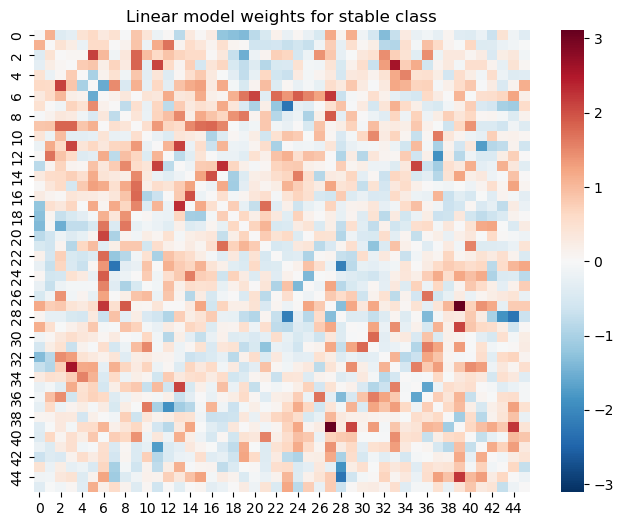

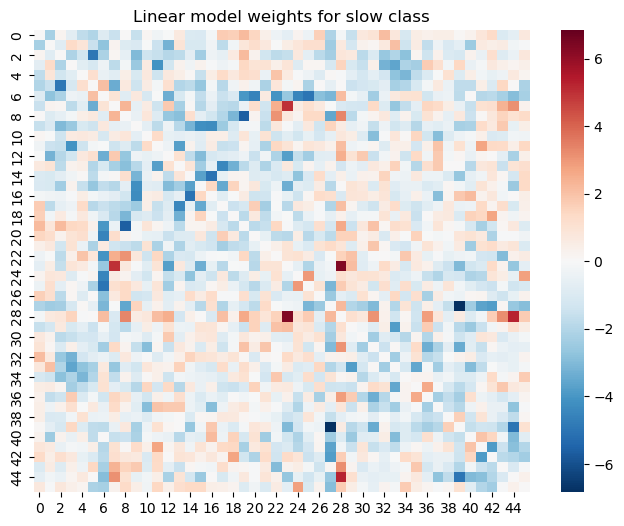

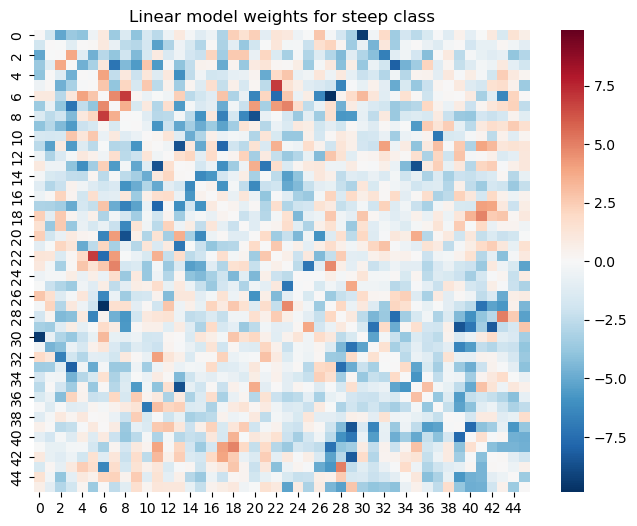

In [13]:
from nilearn.connectome import vec_to_sym_matrix

def region_split(label):
    return label.split("_")[-2]

class MockAtlas:
    if atlas.name == "schaefer200":
        macro_labels = list(map(region_split, regions))
    else:
        macro_labels = regions
    
cats = ("stable", "slow", "steep")
for i in range(k):

    coefs = reg.coef_[i, :]

    # Perform Hauf transform to make coefs interpretable
    X = masker.transform(matrices)
    patterns = np.cov(X.T) @ coefs

    arr = vec_to_sym_matrix(patterns, diagonal=np.zeros(n_regions))
    cat = cats[i]
    axes = plot_matrix(
        np.where(np.abs(arr) > 0, arr, 0),
        MockAtlas(),
        cmap="RdBu_r",
        #bounds=(-10, 10),
        macro_labels=False
    )
    axes.set_title(f"Linear model weights for {cat} class")
    plt.show()

In [14]:
test_scores = cross_val_score(
    search,
    matrices,
    y,
    cv=outer_cv.split(matrices, y, groups=metadata.CEN_ANOM.values),
    n_jobs=8,
    scoring=macro_f1,
    verbose=1,
    params={"groups": metadata.CEN_ANOM.values} # This is for inner cv
)
test_scores

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

array([0.32473367, 0.37405732, 0.31724255, 0.37357744, 0.35235035,
       0.37867123, 0.27989822, 0.28253968])

In [15]:
import joblib
cv_results.to_csv(run_path / "cv_results.csv")
#joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200_net-Default_inter-Default/best_estimator.joblib']